In [27]:
!pip install numpy

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [29]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [30]:
def onehot_dna(dna_str):
    encoding_dict = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}

    onehot_list = [encoding_dict[base] for base in dna_str if base in encoding_dict]
    return np.array(onehot_list)


In [31]:
onehot_dna('AAT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.


In [32]:
## 1.
y_train = joblib.load('/content/drive/MyDrive/data/data/y_train.joblib')
X_train = joblib.load('/content/drive/MyDrive/data/data/X_train.joblib')

In [33]:
## 2.
y_test = joblib.load('/content/drive/MyDrive/data/data/y_test.joblib')
X_test = joblib.load('/content/drive/MyDrive/data/data/X_test.joblib')

In [34]:
## 3.
print("X_train shape is:", X_train.shape)
print("y_train shape is:", y_train.shape)
print("There are", X_train.shape[0], "DNA segments in the training set")

X_train shape is: (4672, 101, 4)
y_train shape is: (4672, 1)
There are 4672 DNA segments in the training set


In [35]:
print("X_train shape is:", X_test.shape)
print("y_train shape is:", y_test.shape)

X_train shape is: (584, 101, 4)
y_train shape is: (584, 1)


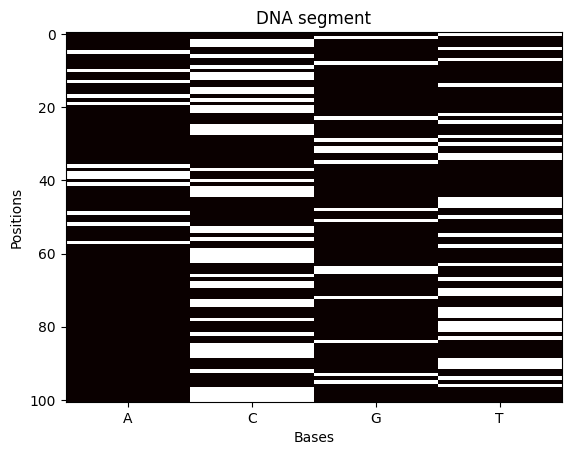

In [36]:
## 4.
dna_segment = X_train[0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dna_segment, cmap='hot', aspect='auto')
ax.set_xticks(range(4), labels= ['A', 'C', 'G', 'T'])
ax.set_xlabel('Bases')
ax.set_ylabel('Positions')
ax.set_title('DNA segment')
plt.show()

In [37]:
dna_segment.shape

(101, 4)

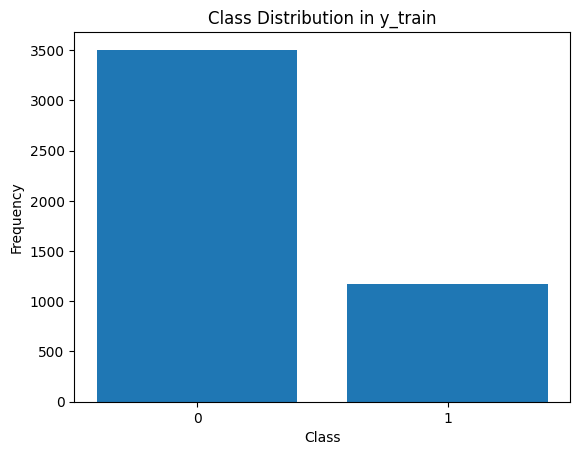

In [38]:
## 5.
unique, counts = np.unique(y_train, return_counts=True)

plt.bar(unique.astype(str), counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in y_train')
plt.show()


# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [39]:
## 1.

X_train = torch.from_numpy(X_train).float().reshape(4672, 4, 101)
y_train = torch.from_numpy(y_train).float()

In [40]:
## 2.
X_test = torch.from_numpy(X_test).float().reshape(584, 4, 101)
y_test = torch.from_numpy(y_test).float()


# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [41]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}

        return sample

In [42]:
## 1.
train_dataset = DNADataset(X_train, y_train)

In [43]:
## 2.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [44]:
## 3.
test_dataset = DNADataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.


2. Apply this layer to **dna_seg** below. What is the size of the output ?


3. [Optional] Display the output by using matplotlib.pyplot.imshow




In [45]:
## 1.
in_channels = 4
out_channels = 8
kernel_size = 3
conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size)

In [46]:
## 2.
dna_seg = train_dataset.dna[0]
dna_seg.size()

torch.Size([4, 101])

In [47]:
output = conv1d(dna_seg)
output.size()

torch.Size([8, 99])

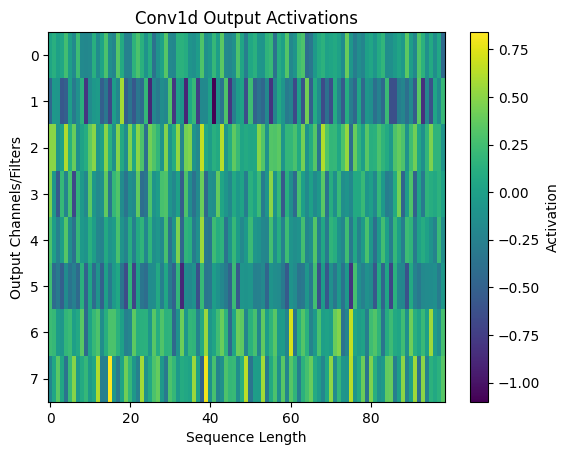

In [48]:
## 3.
dna_seg = dna_seg.unsqueeze(0)  # Adds the batch_size dimension if not added before
output = conv1d(dna_seg)

# Convert the output tensor to a numpy array
output_numpy = output.detach().numpy().squeeze(0)  # Removing batch dimension for visualization

# Plot the activations
plt.imshow(output_numpy, aspect='auto', cmap='viridis')
plt.title('Conv1d Output Activations')
plt.xlabel('Sequence Length')
plt.ylabel('Output Channels/Filters')
plt.colorbar(label='Activation')
plt.show()

# EX 6: Build a model

The following code is used to build a CNN model for a classification problem. This model consists of :

1. 3 layers of  1D-convolution. Each convolutional layer is followed by an activiation ReLu.

2. 2 Linear layers


Complete the lines # TODO below to finish the definition of this network.

In [49]:
class DeepDNA(nn.Module):
    def __init__(self, sequence_length):
        """
        Parameters
        -----------
        sequence_length: int
        num_class: int

        """
        super(DeepDNA, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

        sequence_length = sequence_length - 3 + 1
        sequence_length = sequence_length - 3 + 1
        sequence_length = sequence_length - 3 + 1

        self.lin1 = nn.Linear(sequence_length * 64, 32)
        self.lin2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = torch.sigmoid(x)

        return x


# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

2. Print out the variable **net** to see detailed information about the model.

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

4. What is the size of the output ?



In [50]:
## 1.
net = DeepDNA(sequence_length=101)

In [51]:
## 2.
net

DeepDNA(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (lin1): Linear(in_features=6080, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)

In [54]:
## 3.

net.eval()
output = net(dna_seg)
print(output)


tensor([[0.4931]], grad_fn=<SigmoidBackward0>)


In [55]:
## 4.
output.size()

torch.Size([1, 1])

# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [56]:
## 1.
optimizer = optim.SGD(net.parameters(), lr=0.01)

## 2.
criterion = nn.BCELoss()


# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [57]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        dna = batch['DNA']
        labels = batch['Class'].view(-1, 1)

        optimizer.zero_grad()

        outputs = model(dna)

        loss = criterion(outputs, labels.float())

        loss.backward()

        optimizer.step()

        total_loss += loss.item() * len(labels)

    return total_loss / len(train_loader.dataset)

# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [58]:
def compute_num_correct_pred(y_prob, y_label):
    y_pred = (y_prob > 0.5).float()
    correct = (y_pred == y_label).float().sum()
    return int(correct)


In [59]:
y_prob = torch.tensor([[0.3],[0.4], [0.8], [0.7]])
y_label = torch.tensor([[0], [1], [1], [0]])

num_correct = compute_num_correct_pred(y_prob, y_label)
print(num_correct)

2



The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [60]:
def test(loader):
  net.eval()

  correct = 0
  with torch.no_grad():
    for data in loader:
      dna = data['DNA']
      y = data['Class']

      out = net(dna)
      correct += compute_num_correct_pred(out, y)

  return correct / len(loader.dataset)

In [61]:
accuracy = test(train_loader)
print(f'Model Accuracy: {accuracy * 100:.2f}%')


Model Accuracy: 75.00%


# Ex 12: Training the model

Write code to train your model on 10 epoches to see if everything is going well and then you can try to add more epoches.


In [63]:
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = train_one_epoch(net, train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

Epoch 1, Loss: 0.5622009945242372
Epoch 2, Loss: 0.5620906377491885
Epoch 3, Loss: 0.5620529994572678
Epoch 4, Loss: 0.5620074623251614
Epoch 5, Loss: 0.5618845428505989
Epoch 6, Loss: 0.5617431930891456
Epoch 7, Loss: 0.5616438878725653
Epoch 8, Loss: 0.5617379050140512
Epoch 9, Loss: 0.5616473761731631
Epoch 10, Loss: 0.5613775635010576
Epoch 11, Loss: 0.5616073937040486
Epoch 12, Loss: 0.561491218739993
Epoch 13, Loss: 0.5613152203086305
Epoch 14, Loss: 0.5611190951033814
Epoch 15, Loss: 0.5612935919875968
Epoch 16, Loss: 0.5609696850384751
Epoch 17, Loss: 0.5609965320319346
Epoch 18, Loss: 0.5608710277162187
Epoch 19, Loss: 0.5605272883421755
Epoch 20, Loss: 0.5604952169607763
Epoch 21, Loss: 0.5603704246347898
Epoch 22, Loss: 0.5603139674010342
Epoch 23, Loss: 0.5602554595225477
Epoch 24, Loss: 0.559782838372335
Epoch 25, Loss: 0.5600566837477358
Epoch 26, Loss: 0.5596389711311419
Epoch 27, Loss: 0.5595628043560132
Epoch 28, Loss: 0.5591008240637714
Epoch 29, Loss: 0.5592591319590

# Ex13 (optional)

1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?


2. The same question for torch.nn.CrossEntropyLoss() loss.  